Library

In [59]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import time

Load Grouped Dataframes from Mastra

In [3]:
grouped_dataframes = pd.read_pickle('grouped_dataframes.pkl')

In [4]:
for key in grouped_dataframes.keys():
    grouped_dataframes[key] = grouped_dataframes[key][~grouped_dataframes[key].index.duplicated(keep='first')]

In [5]:
import pandas as pd
import numpy as np
import time

# Define the date range
date_range = pd.date_range(start='2023-01-01', end='2024-08-31', freq='D')

# Define the time range with 15-minute intervals
time_range = pd.date_range(start='00:00', end='23:45', freq='15min').time

# Create a MultiIndex with all combinations of dates and times
multi_index = pd.MultiIndex.from_product([date_range, time_range], names=['Dato', 'time_start'])

# Create the DataFrame
empty_df = pd.DataFrame(index=multi_index, columns=['Vej-Id', 'Xkoordinat', 'Ykoordinat', 'traffic_flow'])

# Reset the index to have 'datetime' as a column
empty_df = empty_df.reset_index()

# Format 'Dato' as mm.dd.yyyy
empty_df['Dato'] = empty_df['Dato'].dt.strftime('%d.%m.%Y')

# Combine 'Dato' and 'time_start' into a single datetime column (ensure correct formatting)
empty_df['datetime'] = pd.to_datetime(empty_df['Dato'] + ' ' + empty_df['time_start'].astype(str), format='%d.%m.%Y %H:%M:%S')

# Convert datetime to UNIX timestamp
empty_df['datetime'] = empty_df['datetime'].apply(lambda dt: int(time.mktime(dt.timetuple())))

# Set 'datetime' as the index
empty_df = empty_df.set_index('datetime')

# Ensure 'time_start' contains only hour and minutes as strings
empty_df['time_start'] = empty_df.index.map(lambda ts: pd.to_datetime(ts, unit='s').strftime('%H:%M'))

# Fill other columns with placeholder data
empty_df['Vej-Id'] = np.nan  # Placeholder for Vej-Id
empty_df['Dato'] = empty_df.index.map(lambda ts: pd.to_datetime(ts, unit='s').strftime('%d.%m.%Y'))  # Re-format Dato column

# Set NaN for other columns
empty_df['Xkoordinat'] = np.nan          # Set NaN for Xkoordinat
empty_df['Ykoordinat'] = np.nan          # Set NaN for Ykoordinat
empty_df['traffic_flow'] = np.nan        # Set NaN for traffic_flow

# Reorder columns
empty_df = empty_df[['Vej-Id', 'Dato', 'Xkoordinat', 'Ykoordinat', 'traffic_flow', 'time_start']]

# Remove the first 4 rows and adjust index
empty_df = empty_df.iloc[4:]
empty_df.index = empty_df.index - 3600  # Subtract 3600 seconds (1 hour) from each index value

# Define the additional time range for 31.08.2024
additional_time_range = pd.date_range(start='2024-08-31 22:00', end='2024-08-31 23:45', freq='15min')

# Create a DataFrame for the new rows
additional_df = pd.DataFrame({
    'datetime': additional_time_range.map(lambda dt: int(time.mktime(dt.timetuple()))),  # Convert to UNIX timestamp
    'Vej-Id': np.nan,
    'Dato': additional_time_range.strftime('%d.%m.%Y'),
    'Xkoordinat': np.nan,
    'Ykoordinat': np.nan,
    'traffic_flow': np.nan,
    'time_start': additional_time_range.strftime('%H:%M'),
})

# Set 'datetime' as the index
additional_df = additional_df.set_index('datetime')

# Append the new rows to the original DataFrame
empty_df = pd.concat([empty_df, additional_df])

# Display the last few rows to verify
empty_df.shape

for key in grouped_dataframes.keys():
    grouped_dataframes[key] = empty_df.combine_first(grouped_dataframes[key])

In [6]:
for key, df in grouped_dataframes.items():
    print("Dupliacted: ", df.index.duplicated().any(), "Length: ", len(df.index), df.index[0], df.index[-1], "notna: ", df['traffic_flow'].notna().sum(), "Toal: ", len(df.index))


Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  56641 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  56641 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  56641 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  56641 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  56641 Toal:  58472
Dupliacted:  Tru

In [ ]:
def adjust_traffic_flow(df, column_name):
    """
    Adjusts the traffic flow value of 1.0 in a DataFrame to 1000 if it is between

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the traffic flow column.

    Returns:
        pd.DataFrame: Modified DataFrame with adjusted traffic flow values.
    """
    traffic_flow = df[column_name].values
    for i in range(1, len(traffic_flow) - 1):
        # Check if the current value is 1.0 and it's between two values that are higher
        if (traffic_flow[i] == 1.0 and 
            traffic_flow[i - 1] > 900 and 
            traffic_flow[i + 1] > 900):
            traffic_flow[i] = 1000
    
    # Update the DataFrame column
    df[column_name] = traffic_flow
    return df

grouped_dataframes = {key: adjust_traffic_flow(df, 'traffic_flow') for key, df in grouped_dataframes.items()}

In [8]:
columns_to_keep = ['Vej-Id', 'Dato', 'Xkoordinat', 'Ykoordinat', 'traffic_flow', 'time_start']
cleaned_dataframes = {}

for key in grouped_dataframes.keys():
    grouped_dataframes[key] = grouped_dataframes[key][columns_to_keep]
    grouped_dataframes[key]['traffic_flow'] = grouped_dataframes[key]['traffic_flow'].apply(lambda x: x * 10**3 if not pd.isna(x) and x != int(x) else x)

    # # check for index duplicates
    # if grouped_dataframes[key].index.duplicated().any():
    #     # drop duplicates
    #     cleaned_dataframes[key] = grouped_dataframes[key].reset_index(drop=True)


C:\Users\gonde\AppData\Local\Temp\ipykernel_9652\3103714261.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_dataframes[key]['traffic_flow'] = grouped_dataframes[key]['traffic_flow'].apply(lambda x: x * 10**3 if not pd.isna(x) and x != int(x) else x)


Only use Total Dataframes

In [9]:
# Filtered and unique dataframes processing
filtered_dataframes = {}
unique_dataframes = {}
cords = []
names = list(grouped_dataframes.keys())
k = 0

for name in names:
    single_name = name[0]
    
    # Check if the name ends with "T"
    if single_name[-1] in ["T"]:
        # Add to filtered dataframes
        filtered_dataframes[name] = grouped_dataframes[name]
        
        # Extract coordinates
        x, y = grouped_dataframes[name]['Xkoordinat'].iloc[0], grouped_dataframes[name]['Ykoordinat'].iloc[0]
        
        # Check for uniqueness and add to unique_dataframes
        if (x, y) not in cords:
            unique_dataframes[name] = grouped_dataframes[name]
            cords.append((x, y))
            k += 1
    
print("Unique Dataframes", k)

Unique Dataframes 136


Look at NA Values

In [10]:
for key in filtered_dataframes.keys():
    df = filtered_dataframes[key]
    print(key, "NA", df['traffic_flow'].isna().sum(), "\n", "NotNA", df['traffic_flow'].notna().sum())

('0 450-0 7/ 300 T', 552601.0, 6329842.0) NA 24939 
 NotNA 33533
('0 450-0 9/1675 T', 549360.0, 6330576.0) NA 1831 
 NotNA 56641
('0 70-0 277/ 100 T', 552269.0, 6311346.0) NA 9656 
 NotNA 48816
('0 70-0 278/ 201 T', 552730.0, 6312348.0) NA 9421 
 NotNA 49051
('0 70-0 279/ 100 T', 553084.0, 6313171.0) NA 28101 
 NotNA 30371
('0 70-0 284/ 400 T', 555132.0, 6317792.0) NA 2017 
 NotNA 56455
('0 70-0 284/ 950 T', 555308.0, 6318304.0) NA 2017 
 NotNA 56455
('0 70-0 285/ 700 T', 555789.0, 6318873.0) NA 29885 
 NotNA 28587
('0 70-0 286/ 100 T', 556145.0, 6319061.0) NA 7520 
 NotNA 50952
('0 70-0 288/ 424 T', 558245.0, 6319907.0) NA 3376 
 NotNA 55096
('0 70-0 289/ 350 T', 558753.0, 6320685.0) NA 20176 
 NotNA 38296
('0 70-0 289/ 950 T', 559007.0, 6321227.0) NA 3917 
 NotNA 54555
('0 70-0 290/ 951 T', 559026.0, 6322227.0) NA 11128 
 NotNA 47344
('0 70-0 291/ 452 T', 558976.0, 6322726.0) NA 3470 
 NotNA 55002
('0 70-0 291/ 625 T', 558956.0, 6322898.0) NA 2236 
 NotNA 56236
('0 70-0 292/ 0 T', 55

Find Longest period and Interpolate NA Values

In [11]:
def find_and_apply_longest_period(filtered_dataframes, threshold=5):
    """
    Loops over all dataframes in filtered_dataframes, finds the longest period 
    without exceeding the threshold of consecutive NaN values, and filters 
    the dataframe to include only that period.

    Parameters:
    - filtered_dataframes (dict): A dictionary of dataframes to process.
    - threshold (int): Maximum allowed consecutive NaN values.

    Returns:
    - dict: Updated filtered_dataframes with filtered dataframes.
    """
    def find_longest_valid_period(series, threshold):
        """
        Finds the longest valid period in the series, allowing up to `threshold` NaN values consecutively.
        """
        mask = series.notna()
        count = 0
        start = end = 0
        max_start = max_end = 0
        nans = 0

        for i in range(len(mask)):
            if mask.iloc[i]:
                count += 1
                nans = 0
            else:
                nans += 1
                if nans > threshold:
                    count = 0
                    nans = 0
                    start = i + 1
            if count > (max_end - max_start):
                max_start, max_end = start, i + 1
        return max_start, max_end

    for name, df in filtered_dataframes.items():
        # Assuming the column to check for NaN values is named 'Value'
        if 'traffic_flow' in df.columns:
            start_idx, end_idx = find_longest_valid_period(df['traffic_flow'], threshold)
            filtered_dataframes[name] = df.iloc[start_idx:end_idx]

    return filtered_dataframes

filtered_dataframes_period = find_and_apply_longest_period(filtered_dataframes.copy(), threshold=5)

In [12]:
for key in filtered_dataframes_period.keys():
    df = filtered_dataframes_period[key]
    print(key, "NA", df['traffic_flow'].isna().sum(), "\n", "NotNA", df['traffic_flow'].notna().sum())

('0 450-0 7/ 300 T', 552601.0, 6329842.0) NA 1079 
 NotNA 33194
('0 450-0 9/1675 T', 549360.0, 6330576.0) NA 1795 
 NotNA 55524
('0 70-0 277/ 100 T', 552269.0, 6311346.0) NA 135 
 NotNA 4135
('0 70-0 278/ 201 T', 552730.0, 6312348.0) NA 152 
 NotNA 4700
('0 70-0 279/ 100 T', 553084.0, 6313171.0) NA 135 
 NotNA 4135
('0 70-0 284/ 400 T', 555132.0, 6317792.0) NA 1078 
 NotNA 33367
('0 70-0 284/ 950 T', 555308.0, 6318304.0) NA 1078 
 NotNA 33367
('0 70-0 285/ 700 T', 555789.0, 6318873.0) NA 501 
 NotNA 15481
('0 70-0 286/ 100 T', 556145.0, 6319061.0) NA 501 
 NotNA 15481
('0 70-0 288/ 424 T', 558245.0, 6319907.0) NA 432 
 NotNA 13411
('0 70-0 289/ 350 T', 558753.0, 6320685.0) NA 335 
 NotNA 10312
('0 70-0 289/ 950 T', 559007.0, 6321227.0) NA 268 
 NotNA 8320
('0 70-0 290/ 951 T', 559026.0, 6322227.0) NA 281 
 NotNA 8656
('0 70-0 291/ 452 T', 558976.0, 6322726.0) NA 471 
 NotNA 14679
('0 70-0 291/ 625 T', 558956.0, 6322898.0) NA 418 
 NotNA 12821
('0 70-0 292/ 0 T', 558880.0, 6323318.0) NA

In [13]:
for name, df in filtered_dataframes_period.items():
    # Interpolate NaN values in all columns with numeric data
    filtered_dataframes_period[name]['traffic_flow'] = df['traffic_flow'].interpolate(method='linear', limit_direction='both')


C:\Users\gonde\AppData\Local\Temp\ipykernel_9652\2306075207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataframes_period[name]['traffic_flow'] = df['traffic_flow'].interpolate(method='linear', limit_direction='both')


Verify amount of Na Values

In [14]:
# longest consecutive streak of NA in filtered_dataframes_period[name]['traffic_flow']
for name in filtered_dataframes_period:
    print(name, filtered_dataframes_period[name]['traffic_flow'].isna().astype(int).groupby(filtered_dataframes_period[name]['traffic_flow'].notna().astype(int).cumsum()).cumsum().max(), len(filtered_dataframes_period[name]['traffic_flow']))

('0 450-0 7/ 300 T', 552601.0, 6329842.0) 0 34273
('0 450-0 9/1675 T', 549360.0, 6330576.0) 0 57319
('0 70-0 277/ 100 T', 552269.0, 6311346.0) 0 4270
('0 70-0 278/ 201 T', 552730.0, 6312348.0) 0 4852
('0 70-0 279/ 100 T', 553084.0, 6313171.0) 0 4270
('0 70-0 284/ 400 T', 555132.0, 6317792.0) 0 34445
('0 70-0 284/ 950 T', 555308.0, 6318304.0) 0 34445
('0 70-0 285/ 700 T', 555789.0, 6318873.0) 0 15982
('0 70-0 286/ 100 T', 556145.0, 6319061.0) 0 15982
('0 70-0 288/ 424 T', 558245.0, 6319907.0) 0 13843
('0 70-0 289/ 350 T', 558753.0, 6320685.0) 0 10647
('0 70-0 289/ 950 T', 559007.0, 6321227.0) 0 8588
('0 70-0 290/ 951 T', 559026.0, 6322227.0) 0 8937
('0 70-0 291/ 452 T', 558976.0, 6322726.0) 0 15150
('0 70-0 291/ 625 T', 558956.0, 6322898.0) 0 13239
('0 70-0 292/ 0 T', 558880.0, 6323318.0) 0 13239
('0 70-0 293/ 370 T', 557951.0, 6324241.0) 0 4410
('0 70-0 293/ 400 T', 557929.0, 6324261.0) 0 14667
('0 70-0 293/ 640 T', 557757.0, 6324428.0) 0 5272
('0 70-0 293/ 960 T', 557594.0, 6324700.0)

Find the dataframes which have the most data over the longest time

In [15]:
def remove_extreme_dataframes(one_week_dfs, n, m):
    # Sort dataframes by their starting index value
    sorted_by_start = sorted(one_week_dfs.items(), key=lambda item: item[1].index[0])
    
    # Sort dataframes by their ending index value
    sorted_by_end = sorted(one_week_dfs.items(), key=lambda item: item[1].index[-1])
    
    # Remove n dataframes with the highest starting index value
    to_remove_start = sorted_by_start[-n:]
    
    # Remove m dataframes with the lowest ending index value
    to_remove_end = sorted_by_end[:m]
    
    # Create a set of keys to remove
    keys_to_remove = set(key for key, _ in to_remove_start + to_remove_end)
    
    # Remove the dataframes from one_week_dfs
    one_week_dfs = {key: df for key, df in one_week_dfs.items() if key not in keys_to_remove}
    
    return one_week_dfs

highest_duration = 0
count_removing = 200

for n in range(0, 80):
    for m in range(0, 80):
        temp_one_week_dfs = remove_extreme_dataframes(filtered_dataframes_period, n, m)
        
        if temp_one_week_dfs:  # Check if temp_one_week_dfs is not empty
            highest_starting_index = max(df.index[0] for df in temp_one_week_dfs.values())
            lowest_ending_index = min(df.index[-1] for df in temp_one_week_dfs.values())
            duration_days = ((lowest_ending_index - highest_starting_index) / 3600) / 24
            if duration_days >= 0 and duration_days > highest_duration:
                print(f"n = {n}, m = {m}")
                print("Number of dataframes after removal:", len(temp_one_week_dfs))
                print("Highest starting index value:", highest_starting_index)
                print("Lowest ending index value:", lowest_ending_index)
                print("Duration in days:", duration_days)
                if duration_days > highest_duration and count_removing > n+m:	
                    highest_duration = duration_days
                    count_removing = n + m
                    best_start = highest_starting_index
                    best_end = lowest_ending_index
                    best_n = n
                    best_m = m


print("Best start:", best_start)
print("Best end:", best_end)
print("Best n:", best_n)
print("Best m:", best_m)
print("Highest duration in days:", highest_duration)


n = 18, m = 67
Number of dataframes after removal: 52
Highest starting index value: 1703285100
Lowest ending index value: 1703476800
Duration in days: 2.21875
n = 18, m = 70
Number of dataframes after removal: 49
Highest starting index value: 1703285100
Lowest ending index value: 1703523600
Duration in days: 2.7604166666666665
n = 18, m = 71
Number of dataframes after removal: 48
Highest starting index value: 1703285100
Lowest ending index value: 1703523600
Duration in days: 2.7604166666666665
n = 18, m = 72
Number of dataframes after removal: 47
Highest starting index value: 1703285100
Lowest ending index value: 1703523600
Duration in days: 2.7604166666666665
n = 18, m = 73
Number of dataframes after removal: 46
Highest starting index value: 1703285100
Lowest ending index value: 1703523600
Duration in days: 2.7604166666666665
n = 18, m = 74
Number of dataframes after removal: 45
Highest starting index value: 1703285100
Lowest ending index value: 1703523600
Duration in days: 2.76041666

Drop Duplicates in index and apply the Range

In [16]:
n = 79  # Number of dataframes to remove with the highest starting index value
m = 62  # Number of dataframes to remove with the lowest ending index value
final_dataframes = remove_extreme_dataframes(filtered_dataframes_period, n, m)

In [17]:
start = 1672527600# - 3588300
end = 1703530800

final_dataframes = {}

for name, df in filtered_dataframes_period.items():
    # Ensure the index is unique and monotonic
    if not df.index.is_unique:
        print(f"Duplicate indices found in {name}. Dropping duplicates.")
        # print ducplicates
        df = df[~df.index.duplicated(keep='first')]

    if not df.index.is_monotonic_increasing:
        print(f"Index of {name} is not sorted. Sorting the index.")
        df = df.sort_index()

    if start in df.index and end in df.index:
        final_dataframes[name] = df.loc[start:end]
    # elif start > df.index[0] and end < df.index[-1]:
    #     try:
    #         final_dataframes[name] = df.loc[start:end]
    #     except KeyError:
    #         print("Trying something else")
    #         # Find the nearest index to start and end
    #         start_index = df.index.get_indexer([start], method='nearest')[0]
    #         end_index = df.index.get_indexer([end], method='nearest')[0]
    #         final_dataframes[name] = df.iloc[start_index:end_index+1]
    else:
        print(f"Data range does not fit for {name}. Skipping. Start: {start-df.index[0]}, End: {df.index[-1]-end}")
print("Final Dataframes", len(final_dataframes))


Duplicate indices found in ('0 450-0 7/ 300 T', 552601.0, 6329842.0). Dropping duplicates.
Data range does not fit for ('0 450-0 7/ 300 T', 552601.0, 6329842.0). Skipping. Start: -378000, End: 216000
Duplicate indices found in ('0 450-0 9/1675 T', 549360.0, 6330576.0). Dropping duplicates.
Duplicate indices found in ('0 70-0 277/ 100 T', 552269.0, 6311346.0). Dropping duplicates.
Data range does not fit for ('0 70-0 277/ 100 T', 552269.0, 6311346.0). Skipping. Start: -10368900, End: -16792200
Duplicate indices found in ('0 70-0 278/ 201 T', 552730.0, 6312348.0). Dropping duplicates.
Data range does not fit for ('0 70-0 278/ 201 T', 552730.0, 6312348.0). Skipping. Start: -35422200, End: 8781300
Duplicate indices found in ('0 70-0 279/ 100 T', 553084.0, 6313171.0). Dropping duplicates.
Data range does not fit for ('0 70-0 279/ 100 T', 553084.0, 6313171.0). Skipping. Start: -10368900, End: -16792200
Duplicate indices found in ('0 70-0 284/ 400 T', 555132.0, 6317792.0). Dropping duplicates

In [18]:
# Gather all start and end index values for analysis
start_values = []
end_values = []

for name, df in final_dataframes.items():
    start_values.append(df.index[0])
    end_values.append(df.index[-1])

start_values = pd.Series(start_values)
end_values = pd.Series(end_values)

# Determine the most common start and end indices
common_start = start_values.value_counts().idxmax()
common_end = end_values.value_counts().idxmax()

# Apply the common range to all DataFrames
updated_final_dataframes = {}
for name, df in final_dataframes.items():
    # Check if the common_start and common_end exist in the DataFrame
    if common_start in df.index and common_end in df.index:
        updated_final_dataframes[name] = df.loc[common_start:common_end].copy()
    else:
        print(f"Skipping {name} - range {common_start} to {common_end} not found. Dataframe start: {df.index[0]}, end: {df.index[-1]} Diff start: {common_start - df.index[0]}, end: {df.index[-1] - common_end}")

# Replace the final_dataframes with updated ones
final_dataframes = updated_final_dataframes

# Verify results
print(f"Updated DataFrames: {len(final_dataframes)}")
for name, df in final_dataframes.items():
    print(f"{name}: Start {df.index[0]}, End {df.index[-1]}, Length {len(df)}")


Updated DataFrames: 26
('0 450-0 9/1675 T', 549360.0, 6330576.0): Start 1672527600, End 1703530800, Length 34449
('0 70-3 284/ 780 T', 555292.0, 6318128.0): Start 1672527600, End 1703530800, Length 34449
('0 70-4 291/ 625 T', 558928.0, 6322894.0): Start 1672527600, End 1703530800, Length 34449
('0 70-5 291/ 625 T', 558981.0, 6322888.0): Start 1672527600, End 1703530800, Length 34449
('0 70-6 285/ 65 T', 555341.0, 6318418.0): Start 1672527600, End 1703530800, Length 34449
('0 77-1 294/ 200 T', 557437.0, 6324871.0): Start 1672527600, End 1703530800, Length 34449
('0 77-2 294/ 200 T', 557426.0, 6324854.0): Start 1672527600, End 1703530800, Length 34449
('0 80-3 296/ 950 T', 558870.0, 6327287.0): Start 1672527600, End 1703530800, Length 34449
('0 80-3 303/ 60 T', 563949.0, 6330413.0): Start 1672527600, End 1703530800, Length 34449
('0 80-4 303/ 405 T', 564139.0, 6330707.0): Start 1672527600, End 1703530800, Length 34449
('0 80-5 303/ 285 T', 564096.0, 6330582.0): Start 1672527600, End 1703

____________________________________________________________________

Create Train data for Graph Creation


In [ ]:
# final_dataframes = pickle.load(open('data_prep/one_year.pkl', 'rb'))

In [74]:
# Define the train ratio
train_ratio = 0.8  # 80% training data

# Split each DataFrame into training and testing parts based on time
df_dict_train = {}
df_dict_test = {}
for key, df in final_dataframes.items():
    n_time_steps = len(df['traffic_flow'])
    train_size = int(n_time_steps * train_ratio)
    df_train = df.iloc[:train_size].copy()
    df_test = df.iloc[train_size:].copy()
    df_dict_train[key] = df_train
    df_dict_test[key] = df_test


Create a Graph from Final Dataframes

In [75]:
def clean_graph(graph):
    # Remove self-loops
    graph = graph.copy()  # Avoid modifying the
    self_loops = list(nx.selfloop_edges(graph))
    graph.remove_edges_from(self_loops)
    
    # Remove duplicate edges (not necessary for undirected graphs in NetworkX)
    # Here just in case your graph is directed or you need further verification
    edges_to_remove = []
    for u, v, data in graph.edges(data=True):
        if graph.number_of_edges(u, v) > 1:  # More than one edge exists
            edges_to_remove.append((u, v))
    
    graph.remove_edges_from(edges_to_remove)
    largest_component = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_component)

    print(f"Removed {len(self_loops)} self-loops and {len(edges_to_remove)} duplicate edges. Choose the Largest Component: {len(largest_component)} nodes.")
    # extract largest component

    return graph

def create_correlation_graph(df_dict, threshold=0.5, weighted=False, degree=2, train_split=[0.7]):
    """
    Create a correlation graph with a maximum degree constraint.
    """
    correlation_graph = nx.Graph()
    correlations_dict = {}

    # Add nodes to the graph
    for key, df in df_dict.items():
        correlation_graph.add_node(
            key, 
            x=df['Xkoordinat'].iloc[0], 
            y=df['Ykoordinat'].iloc[0], 
            traffic_flow=df['traffic_flow'].values
        )

    # Calculate correlations and store in a dictionary
    for key1, df1 in df_dict.items():
        for key2, df2 in df_dict.items():
            if key1 == key2:
                continue
            # Depending on split size only use test 
            correlation = np.corrcoef(df1['traffic_flow'], df2['traffic_flow'])[0, 1]
            correlations_dict[key1, key2] = correlation

    # Add edges based on correlation, enforcing degree constraint
    for key1 in df_dict.keys():
        # Sort potential connections by correlation (highest first)
        potential_edges = [
            (key2, correlations_dict[key1, key2])
            for key2 in df_dict.keys() if key1 != key2 and (key1, key2) in correlations_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: -x[1])  # Sort by descending correlation
        
        for key2, corr in potential_edges:
            if correlation_graph.degree[key1] < degree and correlation_graph.degree[key2] < degree:
                if corr > threshold:
                    if weighted:
                        correlation_graph.add_edge(key1, key2, weight=corr)
                    else:
                        correlation_graph.add_edge(key1, key2)

    # Clean graph
    correlation_graph = clean_graph(correlation_graph)
    return correlation_graph, correlations_dict

def create_correlation_graph_edited(df_dict_full, df_dict_train, threshold=0.5, weighted=False,degree=4):
    """
    Create a correlation graph with a maximum degree constraint using only the training data for correlations.
    """
    correlation_graph = nx.Graph()
    correlations_dict = {}

    # Add nodes to the graph using the full data
    for key, df in df_dict_full.items():
        correlation_graph.add_node(
            key,
            x=df['Xkoordinat'].iloc[0],
            y=df['Ykoordinat'].iloc[0],
            traffic_flow=df['traffic_flow'].values  # Full traffic data
        )

    # Calculate correlations using the training data
    for key1, df1_train in df_dict_train.items():
        for key2, df2_train in df_dict_train.items():
            if key1 >= key2:  # Avoid duplicate computations
                continue
            correlation = np.corrcoef(df1_train['traffic_flow'], df2_train['traffic_flow'])[0, 1]
            correlations_dict[key1, key2] = correlation
            correlations_dict[key2, key1] = correlation  # Symmetric for undirected graph

    # Add edges based on correlation, enforcing degree constraint
    for key1 in df_dict_full.keys():
        # Sort potential connections by correlation (highest first)
        potential_edges = [
            (key2, correlations_dict[key1, key2])
            for key2 in df_dict_full.keys() if key1 != key2 and (key1, key2) in correlations_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: -x[1])  # Sort by descending correlation

        for key2, corr in potential_edges:
            if correlation_graph.degree[key1] < degree and correlation_graph.degree[key2] < degree:
                if corr > threshold:
                    if weighted:
                        correlation_graph.add_edge(key1, key2, weight=corr)
                    else:
                        correlation_graph.add_edge(key1, key2)

    # Clean graph
    correlation_graph = clean_graph(correlation_graph)
    return correlation_graph, correlations_dict


def create_distance_graph(df_dict, weighted=False, degree=4):
    """
    Create a distance graph with a maximum degree constraint.
    """
    distance_graph = nx.Graph()
    distance_dict = {}

    # Add nodes to the graph
    for key, df in df_dict.items():
        distance_graph.add_node(
            key, 
            x=df['Xkoordinat'].iloc[0], 
            y=df['Ykoordinat'].iloc[0], 
            traffic_flow=df['traffic_flow'].values
        )

    # Calculate distances and store in a dictionary
    for key1, df1 in df_dict.items():
        for key2, df2 in df_dict.items():
            if key1 == key2:
                continue
            idx = df1['traffic_flow'].first_valid_index()
            distance = math.sqrt(
                (df1['Xkoordinat'][idx] - df2['Xkoordinat'][idx])**2 +
                (df1['Ykoordinat'][idx] - df2['Ykoordinat'][idx])**2
            )
            distance_dict[key1, key2] = distance

    # Add edges based on distance, enforcing degree constraint
    threshold = sum(distance_dict.values()) / len(distance_dict)  # Distance threshold
    for key1 in df_dict.keys():
        # Sort potential connections by distance (shortest first)
        potential_edges = [
            (key2, distance_dict[key1, key2])
            for key2 in df_dict.keys() if key1 != key2 and (key1, key2) in distance_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: x[1])  # Sort by ascending distance
        
        for key2, dist in potential_edges:
            if distance_graph.degree[key1] < degree and distance_graph.degree[key2] < degree:
                if dist < threshold:
                    if weighted:
                        max_distance = max(distance_dict.values())
                        min_distance = min(distance_dict.values())
                        normalised_distance = (dist - min_distance) / (max_distance - min_distance)
                        distance_graph.add_edge(key1, key2, weight=normalised_distance)
                    else:
                        distance_graph.add_edge(key1, key2)

    # Clean graph
    distance_graph = clean_graph(distance_graph)
    return distance_graph, distance_dict

def create_fully_connected_graph(df_dict):
    # Connect every node to every other node without weights 
    fully_connected_graph = nx.complete_graph(len(df_dict))

    # Add attributes to the nodes
    for i, (key, df) in enumerate(df_dict.items()):
        fully_connected_graph.nodes[i]['x'] = df['Xkoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['y'] = df['Ykoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['traffic_flow'] = df['traffic_flow'].values
        
    return fully_connected_graph

def create_fully_connected_graph_RANDOM_WEIGHTS(df_dict):
    # Connect every node to every other node without weights 
    fully_connected_graph = nx.complete_graph(len(df_dict))

    # Add attributes to the nodes
    for i, (key, df) in enumerate(df_dict.items()):
        fully_connected_graph.nodes[i]['x'] = df['Xkoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['y'] = df['Ykoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['traffic_flow'] = df['traffic_flow'].values

    # Add random weights to the edges
    for u, v in fully_connected_graph.edges:
        fully_connected_graph[u][v]['weight'] = np.random.rand()
        
    return fully_connected_graph, nx.get_edge_attributes(fully_connected_graph, 'weight')

distance_graph_weighted, distance_dict = create_distance_graph(final_dataframes, weighted=True, degree=20)
correlation_graph_weighted, correlation_dict = create_correlation_graph(final_dataframes, threshold=0.8, weighted=True, degree=20)

# New Correlation Graph
df_dict = final_dataframes
correlation_graph_weighted_edited, correlation_dict_edited = create_correlation_graph_edited(df_dict_full=df_dict, df_dict_train=df_dict_train, threshold=0.8, weighted=True, degree=20)


# Calculate the unweighted version of the graph 
distance_graph_unweighted, _ = create_distance_graph(final_dataframes, weighted=False, degree=20)
correlation_graph_unweighted, _ = create_correlation_graph(final_dataframes, threshold=0.5, weighted=False, degree=20)

fully_connected_graph = create_fully_connected_graph(final_dataframes)
fully_connected_graph_RANDOM_WEIGHTS, fully_connected_weights = create_fully_connected_graph_RANDOM_WEIGHTS(final_dataframes)


Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 31 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 30 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 30 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 31 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 32 nodes.


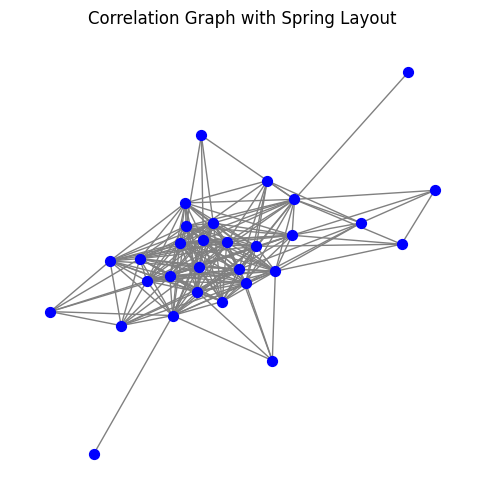

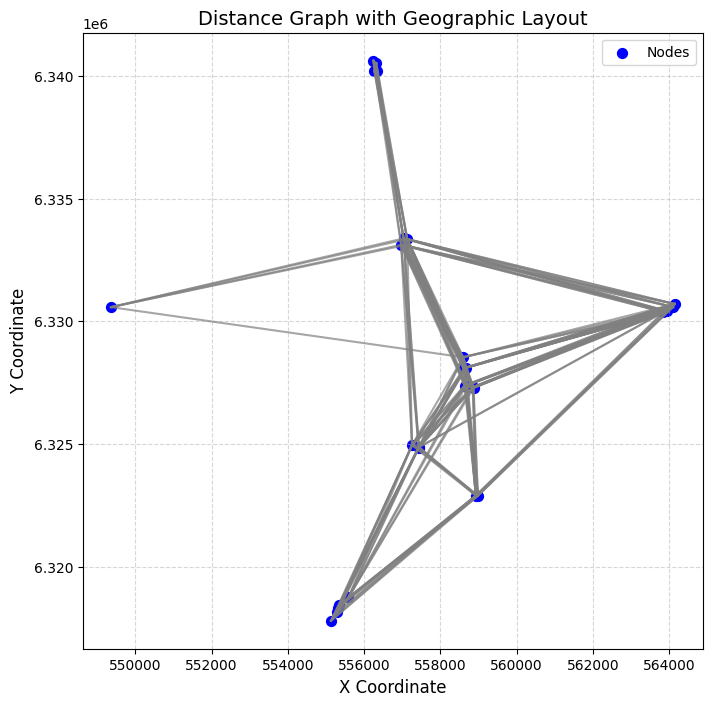

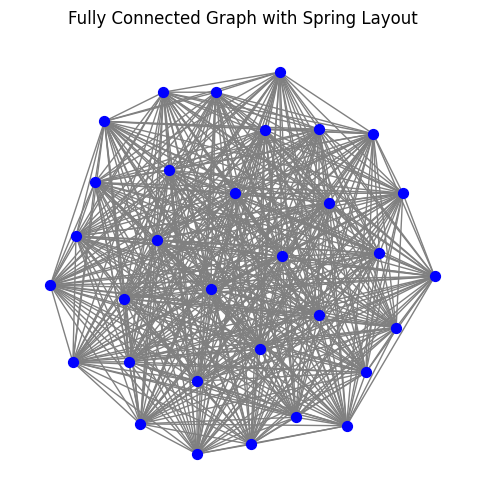

In [76]:
# Plot the Correlation graph without labels or edge attributes, use a spring layout, with a title that explain how they where plotted
plt.figure(figsize=(6, 6))
plt.title("Correlation Graph with Spring Layout")
pos = nx.spring_layout(correlation_graph_weighted)
nx.draw(correlation_graph_weighted, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.show()

# Extract positions from the graph's node attributes
pos = {node: (data['x'], data['y']) for node, data in distance_graph_weighted.nodes(data=True)}

# Extract x and y coordinates for nodes
x_values = [coord[0] for coord in pos.values()]
y_values = [coord[1] for coord in pos.values()]

# Plot the distance graph
plt.figure(figsize=(8, 8))
plt.title("Distance Graph with Geographic Layout", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.scatter(x_values, y_values, c='blue', s=50, label='Nodes')


for edge in distance_graph_weighted.edges():
    x_coords = [pos[edge[0]][0], pos[edge[1]][0]]
    y_coords = [pos[edge[0]][1], pos[edge[1]][1]]
    plt.plot(x_coords, y_coords, color='gray', alpha=0.7)

# Set axis labels
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)


# Show legend
plt.legend()
# Display the plot
plt.show()

# Plot the Correlation graph without labels or edge attributes, use a spring layout, with a title that explain how they where plotted
plt.figure(figsize=(6, 6))
plt.title("Fully Connected Graph with Spring Layout")
pos = nx.spring_layout(fully_connected_graph)
nx.draw(fully_connected_graph, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.show()

Create GCN Model with Splitting data before calculating

In [77]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [91]:
# Define GNN model
class Baseline(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.conv6 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.conv6(x, edge_index)
        x = self.fc(x)
        return x
    

# Define GNN model
class TrafficGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = self.fc(x)
        return x

In [92]:
def create_sliding_window_data(df_dict, lookback, pred_horizon):
    X_dict = {}
    y_dict = {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node = []
        y_node = []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i + lookback])  # Input: Lookback window
            y_node.append(node_series[i + lookback:i + lookback + pred_horizon])  # Output: Next step(s)
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict


# Sliding window parameters
lookback = 50  # Number of time steps to look back
pred_horizon = 1  # Predict the next time step

# Generate sliding window data for training and testing sets
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)



In [93]:
# Combine training data from all nodes
X_train_list = []
y_train_list = []
for key in X_train_dict:
    X_train_list.append(X_train_dict[key])
    y_train_list.append(y_train_dict[key])

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

# Combine testing data from all nodes
X_test_list = []
y_test_list = []
for key in X_test_dict:
    X_test_list.append(X_test_dict[key])
    y_test_list.append(y_test_dict[key])

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float)  # Shape: [num_train_samples, lookback]
y_train = torch.tensor(y_train, dtype=torch.float)  # Shape: [num_train_samples, pred_horizon]

X_test = torch.tensor(X_test, dtype=torch.float)    # Shape: [num_test_samples, lookback]
y_test = torch.tensor(y_test, dtype=torch.float)    # Shape: [num_test_samples, pred_horizon]

from sklearn.model_selection import train_test_split

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)


In [94]:
# Prepare graph edges with integer mapping
node_mapping = {node: idx for idx, node in enumerate(correlation_graph_weighted.nodes())}

edge_index = torch.tensor(
    [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in correlation_graph_weighted.edges],
    dtype=torch.long
).t().contiguous()


from torch_geometric.data import Data

train_data = Data(x=X_train, edge_index=edge_index, y=y_train.view(-1, pred_horizon))
val_data = Data(x=X_val, edge_index=edge_index, y=y_val.view(-1, pred_horizon))
test_data = Data(x=X_test, edge_index=edge_index, y=y_test.view(-1, pred_horizon))



In [112]:
# Initialize model, optimizer, and loss function
hc = 32
model = Baseline(in_channels=lookback, hidden_channels=hc, out_channels=pred_horizon)
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# Lists to store actual and predicted values for plotting
actual_values = []
predicted_values = []

# Training loop with validation
model.train()
for epoch in range(10000):
    optimizer.zero_grad()
    
    # Forward pass on training data
    out = model(train_data)
    train_loss = criterion(out, train_data.y)
    
    # Backward pass
    train_loss.backward()
    optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_out = model(val_data)
        val_loss = criterion(val_out, val_data.y)

        # Store actual and predicted values after each epoch
        actual_values = val_data.y.cpu().numpy()
        predicted_values = val_out.cpu().numpy()
    
    model.train()  # Switch back to training mode

    # Store losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print loss every 100 epochs
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")


# Convert actual and predicted values to numpy arrays for plotting
actual_values = np.vstack(actual_values)
predicted_values = np.vstack(predicted_values)

Epoch 0, Training Loss: 31648.552734375, Validation Loss: 31045.884765625
Epoch 1, Training Loss: 31474.51171875, Validation Loss: 30871.078125
Epoch 2, Training Loss: 31298.9453125, Validation Loss: 30694.751953125
Epoch 3, Training Loss: 31121.869140625, Validation Loss: 30516.9375
Epoch 4, Training Loss: 30943.29296875, Validation Loss: 30337.650390625
Epoch 5, Training Loss: 30763.2421875, Validation Loss: 30156.875
Epoch 6, Training Loss: 30581.73046875, Validation Loss: 29974.564453125
Epoch 7, Training Loss: 30398.740234375, Validation Loss: 29790.775390625
Epoch 8, Training Loss: 30214.275390625, Validation Loss: 29605.55078125
Epoch 9, Training Loss: 30028.337890625, Validation Loss: 29418.935546875
Epoch 10, Training Loss: 29840.8984375, Validation Loss: 29230.93359375
Epoch 11, Training Loss: 29651.97265625, Validation Loss: 29041.486328125
Epoch 12, Training Loss: 29461.595703125, Validation Loss: 28850.6640625
Epoch 13, Training Loss: 29269.8203125, Validation Loss: 28658.

KeyboardInterrupt: 

Evaluations

In [151]:
# Eval model
model.eval()
test_out = model(test_data)
test_loss = criterion(test_out, test_data.y)
test_rmse = torch.sqrt(test_loss).item()
test_mae = torch.mean(torch.abs(test_out - test_data.y)).item()
print(f"Test Loss: {test_loss.item():.2f}, Test MAE: {test_mae:.2f}, Test RMSE: {test_rmse:.2f}")


Test Loss: 29422.75, Test MAE: 70.31, Test RMSE: 171.53


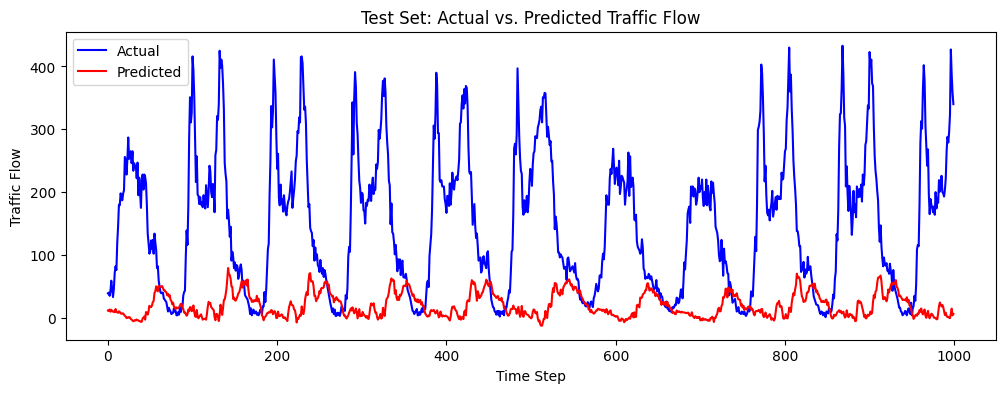

In [152]:
# Plot test prediction results
plt.figure(figsize=(12, 4))
plt.plot(test_data.y.cpu().numpy().flatten()[4000:5000], label='Actual', color='blue')
plt.plot(test_out.detach().numpy().flatten()[4000:5000], label='Predicted', color='red')

plt.title("Test Set: Actual vs. Predicted Traffic Flow")
plt.xlabel("Time Step")
plt.ylabel("Traffic Flow")
plt.legend()
plt.show()

Plot

In [115]:
# Convert actual and predicted values to numpy arrays for plotting
actual_values_stack = np.vstack(actual_values)
predicted_values_stack = np.vstack(predicted_values)

In [116]:
len(predicted_values_stack)

88029

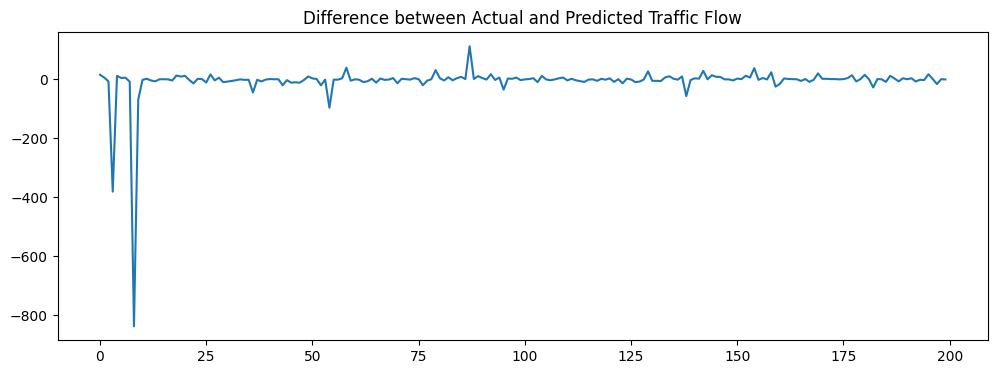

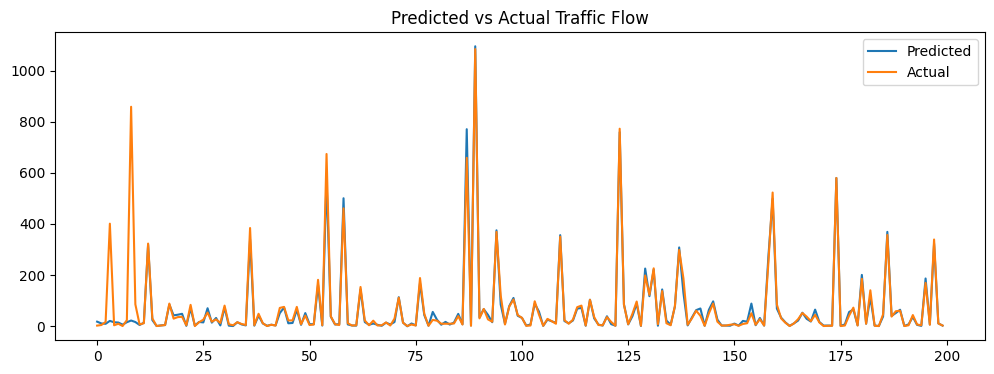

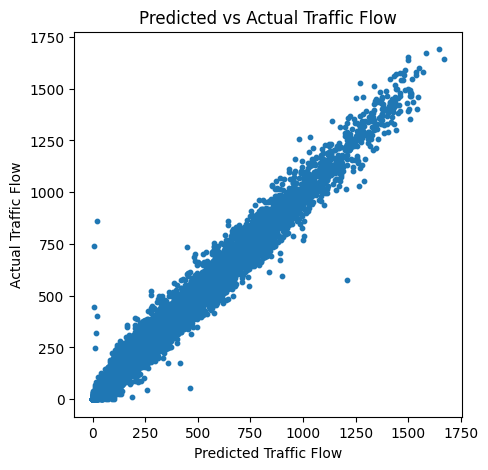

In [153]:
#  Plot the difference between actual and predicted values

plt.figure(figsize=(12, 4))
plt.title("Difference between Actual and Predicted Traffic Flow")
plt.plot(predicted_values_stack[20:220] - actual_values_stack[20:220])


plt.figure(figsize=(12, 4))
plt.title("Predicted vs Actual Traffic Flow")
plt.plot(predicted_values_stack[20:220])
plt.plot(actual_values_stack[20:220])
plt.legend(['Predicted', 'Actual'])
plt.show()

# make a scatter plot of the first 100 predictions
plt.figure(figsize=(5, 5))
plt.scatter(predicted_values_stack, actual_values_stack, s=10)
plt.xlabel('Predicted Traffic Flow')
plt.ylabel('Actual Traffic Flow')
plt.title('Predicted vs Actual Traffic Flow')
plt.show()

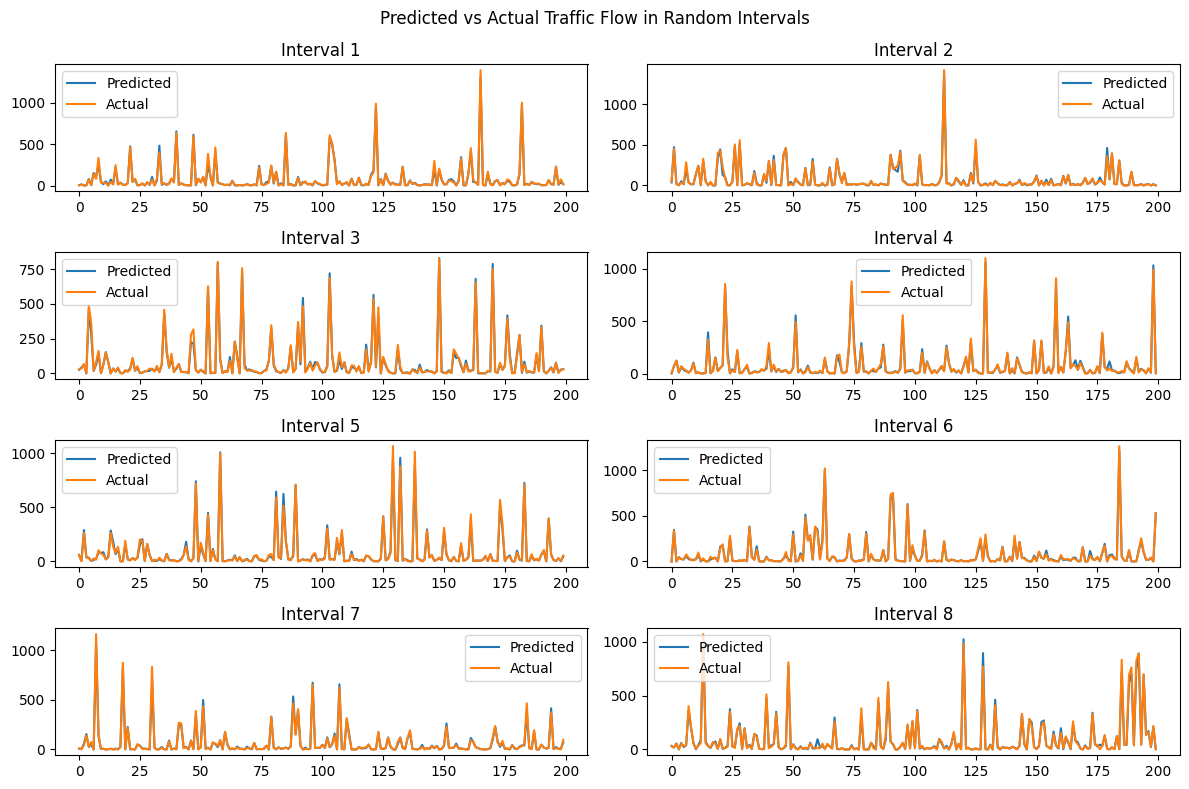

In [121]:
# Make 4 subplots which show 4 randomly chosen intervals of 200 predictions and their actual values. 
# The x-axis should represent the time steps and the y-axis the traffic flow values.
fig, axs = plt.subplots(4, 2, figsize=(12, 8))
fig.suptitle('Predicted vs Actual Traffic Flow in Random Intervals')


for i, ax in enumerate(axs.flat):
    start = np.random.randint(0, len(predicted_values_stack) - 200)
    end = start + 200

    ax.plot(predicted_values_stack[start:end], label='Predicted')
    ax.plot(actual_values_stack[start:end], label='Actual')
    ax.set_title(f'Interval {i+1}')
    ax.legend()

plt.tight_layout()
plt.show()


# Test Everything

In [150]:
# Models to evaluate
amount_degrees = 10
# Models to evaluate
graph_models = {
    "Distance_Weighted": lambda: create_distance_graph(final_dataframes, weighted=True, degree=amount_degrees),
    "Distance_Unweighted": lambda: create_distance_graph(final_dataframes, weighted=False, degree=amount_degrees),
    "Correlation_Weighted": lambda: create_correlation_graph_edited(final_dataframes, df_dict_train, threshold=0.6, weighted=True, degree=amount_degrees),
    "Correlation_Unweighted": lambda: create_correlation_graph_edited(final_dataframes,df_dict_train, threshold=0.6, weighted=False, degree=amount_degrees),
    "Fully_Connected": lambda: (create_fully_connected_graph(final_dataframes), None),
    "Fully_Connected_random_weights": lambda: (create_fully_connected_graph_RANDOM_WEIGHTS(final_dataframes))
}

# Initialize results dictionary
results = {}

# Model parameters
hc = 32
lookback = 50
pred_horizon = 1

# Train and evaluate each model
for model_name, graph_fn in graph_models.items():
    print(f"Running model: {model_name}")
    
    # Create graph and prepare data
    graph, _ = graph_fn()
    

    # Sliding window parameters
    lookback = 50  # Number of time steps to look back
    pred_horizon = 1  # Predict the next time step

    # Generate sliding window data for training and testing sets
    X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
    X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)

    # Combine training data from all nodes
    X_train_list = []
    y_train_list = []
    for key in X_train_dict:
        X_train_list.append(X_train_dict[key])
        y_train_list.append(y_train_dict[key])

    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)

    # Combine testing data from all nodes
    X_test_list = []
    y_test_list = []
    for key in X_test_dict:
        X_test_list.append(X_test_dict[key])
        y_test_list.append(y_test_dict[key])

    X_test = np.concatenate(X_test_list, axis=0)
    y_test = np.concatenate(y_test_list, axis=0)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float)  # Shape: [num_train_samples, lookback]
    y_train = torch.tensor(y_train, dtype=torch.float)  # Shape: [num_train_samples, pred_horizon]

    X_test = torch.tensor(X_test, dtype=torch.float)    # Shape: [num_test_samples, lookback]
    y_test = torch.tensor(y_test, dtype=torch.float)    # Shape: [num_test_samples, pred_horizon]

    # Split training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=42
    )


    # Prepare graph edges with integer mapping
    node_mapping = {node: idx for idx, node in enumerate(correlation_graph_weighted.nodes())}

    edge_index = torch.tensor(
        [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in correlation_graph_weighted.edges],
        dtype=torch.long
    ).t().contiguous()



    train_data = Data(x=X_train, edge_index=edge_index, y=y_train.view(-1, pred_horizon))
    val_data = Data(x=X_val, edge_index=edge_index, y=y_val.view(-1, pred_horizon))
    test_data = Data(x=X_test, edge_index=edge_index, y=y_test.view(-1, pred_horizon))


    # Initialize model
    model = TrafficGCN(in_channels=lookback, hidden_channels=hc, out_channels=pred_horizon)
    optimizer = Adam(model.parameters(), lr=0.0)
    criterion = torch.nn.MSELoss()

    # Train model
    train_losses = []
    val_losses = []
    actual_values = []
    predicted_values = []

    for epoch in range(200):
        optimizer.zero_grad()
        
        # Training
        model.train()
        out = model(train_data)
        train_loss = criterion(out, train_data.y)
        train_loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(val_data)
            val_loss = criterion(val_out, val_data.y)
            actual_values.append(val_data.y.cpu().numpy())
            predicted_values.append(val_out.cpu().numpy())
        
        # Track losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        if epoch % 10 == 0:
            print(f"{model_name} - Epoch {epoch}: Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}")

    # Save results
    results[model_name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "actual_values": np.vstack(actual_values),
        "predicted_values": np.vstack(predicted_values)
    }

Running model: Distance_Weighted
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 31 nodes.
Distance_Weighted - Epoch 0: Train Loss: 32601.11328125, Val Loss: 32213.73828125


KeyboardInterrupt: 

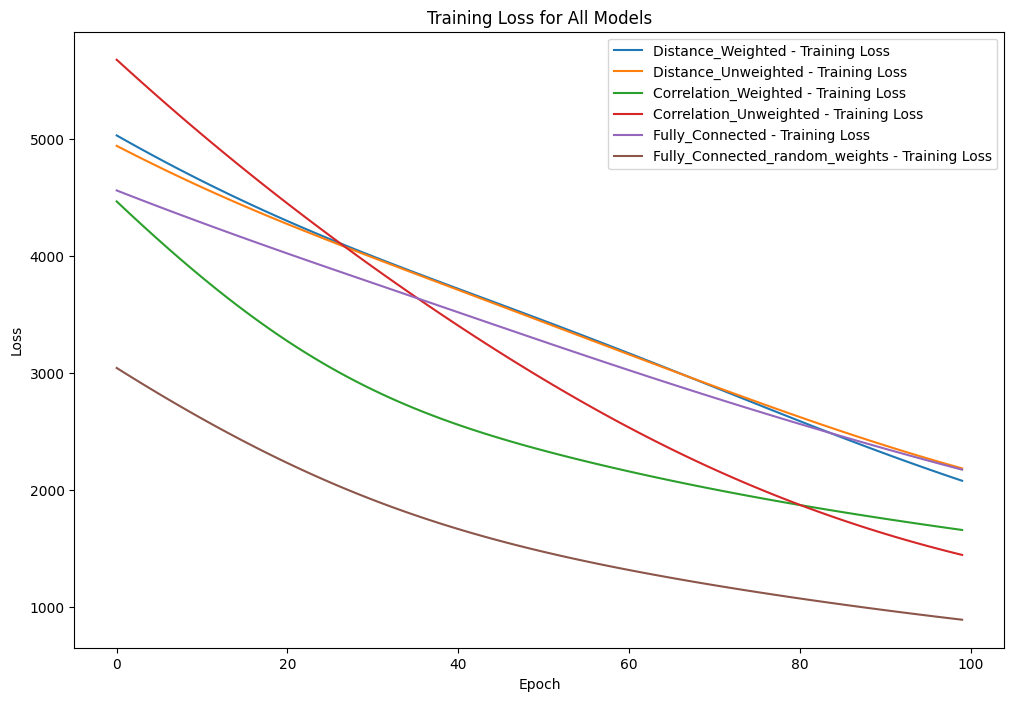

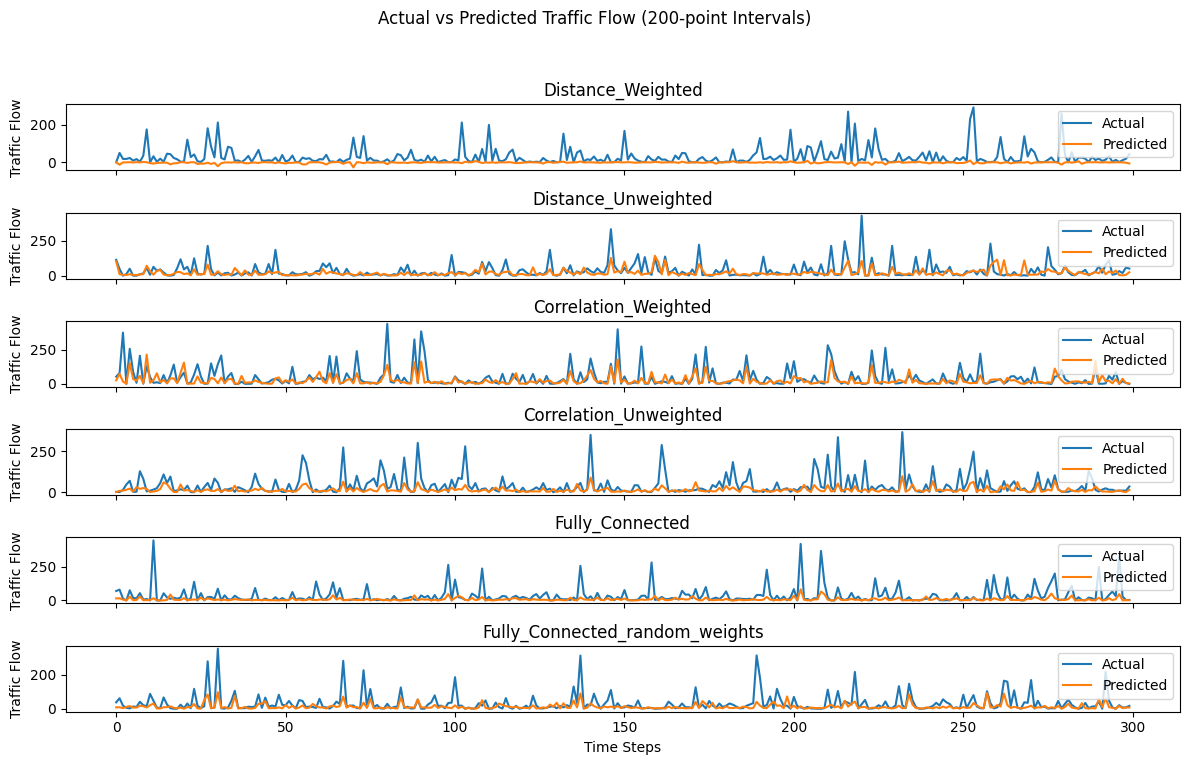

In [ ]:
# Combined plot for train and validation losses
plt.figure(figsize=(12, 8))
for model_name, result in results.items():
    plt.plot(result['train_losses'], label=f'{model_name} - Training Loss')
plt.title("Training Loss for All Models")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Combined actual vs predicted plots in subplots
fig, axs = plt.subplots(len(results), 1, figsize=(12, 8), sharex=True)
fig.suptitle("Actual vs Predicted Traffic Flow (200-point Intervals)")

start = np.random.randint(0, len(results[list(results.keys())[0]]) - 300)
end = start + 300

for idx, (model_name, result) in enumerate(results.items()):
    actual = result['actual_values']
    predicted = result['predicted_values']


    axs[idx].plot(actual[start:end], label='Actual')
    axs[idx].plot(predicted[start:end], label='Predicted')
    axs[idx].set_title(f"{model_name}")
    axs[idx].set_ylabel("Traffic Flow")
    axs[idx].legend()


plt.xlabel("Time Steps")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.show()


In [ ]:
# Save the results dictionary
import pickle
with open("model_results.pkl", "wb") as f:
    pickle.dump(results, f)

# Graph Metrics

In [ ]:
def analyze_graph(graph):
    """
    Analyze a graph and return detailed metrics and properties.

    Parameters:
        graph (networkx.Graph): The graph to analyze.

    Returns:
        dict: A dictionary containing the graph's metrics and properties.
    """
    if not isinstance(graph, nx.Graph):
        raise TypeError("The input must be a NetworkX graph.")

    # Ensure the graph is not empty
    if graph.number_of_nodes() == 0:
        return {"error": "The graph is empty."}

    analysis = {}

    # Basic Graph Properties
    analysis['num_nodes'] = graph.number_of_nodes()
    analysis['num_edges'] = graph.number_of_edges()
    analysis['density'] = nx.density(graph)
    analysis['is_directed'] = nx.is_directed(graph)

    # Degree Properties
    degrees = [degree for _, degree in graph.degree()]
    analysis['average_degree'] = np.mean(degrees)
    analysis['degree_distribution'] = degrees

    # Centrality Measures
    analysis['degree_centrality'] = nx.degree_centrality(graph)
    analysis['betweenness_centrality'] = nx.betweenness_centrality(graph)
    analysis['closeness_centrality'] = nx.closeness_centrality(graph)
    analysis['eigenvector_centrality'] = nx.eigenvector_centrality(graph, max_iter=1000)

    # Path and Connectivity
    if nx.is_connected(graph):
        analysis['average_shortest_path_length'] = nx.average_shortest_path_length(graph)
        analysis['diameter'] = nx.diameter(graph)
    else:
        analysis['average_shortest_path_length'] = "Graph is not connected."
        analysis['diameter'] = "Graph is not connected."

    # Clustering
    analysis['clustering_coefficient'] = nx.clustering(graph)
    analysis['average_clustering'] = nx.average_clustering(graph)

    # Components
    components = list(nx.connected_components(graph)) if not nx.is_directed(graph) else list(nx.strongly_connected_components(graph))
    analysis['num_components'] = len(components)
    analysis['largest_component_size'] = max(len(comp) for comp in components)

    # Assortativity
    analysis['degree_assortativity_coefficient'] = nx.degree_assortativity_coefficient(graph)

    # Power-Law Fit for Degree Distribution
    try:
        power_law_fit = np.polyfit(np.log(range(1, len(degrees) + 1)), np.log(sorted(degrees, reverse=True)), 1)
        analysis['power_law_exponent'] = -power_law_fit[0]
    except Exception:
        analysis['power_law_exponent'] = "Could not compute power-law fit."

    # Subgraph Analysis
    analysis['triangles'] = nx.triangles(graph)
    analysis['num_triangles'] = sum(nx.triangles(graph).values()) // 3

    # Spectral Properties
    laplacian_matrix = nx.laplacian_matrix(graph).toarray()
    eigenvalues = np.linalg.eigvals(laplacian_matrix)
    analysis['laplacian_eigenvalues'] = sorted(eigenvalues)

    return analysis


# Analyze the graph
graph_metrics = analyze_graph(correlation_graph_weighted)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

num_nodes: 25
num_edges: 223
density: 0.7433333333333333
is_directed: False
average_degree: 17.84
degree_distribution: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 15, 7, 16, 18, 18, 20, 20, 20, 20, 5, 7, 20, 20]
degree_centrality: {('0 450-0 9/1675 T', 549360.0, 6330576.0): 0.8333333333333333, ('0 70-3 284/ 780 T', 555292.0, 6318128.0): 0.8333333333333333, ('0 70-4 291/ 625 T', 558928.0, 6322894.0): 0.8333333333333333, ('0 70-5 291/ 625 T', 558981.0, 6322888.0): 0.8333333333333333, ('0 70-6 285/ 65 T', 555341.0, 6318418.0): 0.8333333333333333, ('0 77-1 294/ 200 T', 557437.0, 6324871.0): 0.8333333333333333, ('0 77-2 294/ 200 T', 557426.0, 6324854.0): 0.8333333333333333, ('0 80-3 296/ 950 T', 558870.0, 6327287.0): 0.8333333333333333, ('0 80-3 303/ 60 T', 563949.0, 6330413.0): 0.8333333333333333, ('0 80-4 303/ 405 T', 564139.0, 6330707.0): 0.8333333333333333, ('0 80-5 303/ 285 T', 564096.0, 6330582.0): 0.8333333333333333, ('0 80-6 296/ 950 T', 558845.0, 6327312.0): 0.8333333333333333

In [ ]:
# Analyze the graph
graph_metrics = analyze_graph(distance_graph_weighted)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

num_nodes: 25
num_edges: 185
density: 0.6166666666666667
is_directed: False
average_degree: 14.8
degree_distribution: [9, 9, 15, 15, 9, 20, 20, 19, 16, 16, 16, 19, 16, 7, 19, 18, 7, 19, 18, 7, 19, 7, 19, 11, 20]
degree_centrality: {('0 450-0 9/1675 T', 549360.0, 6330576.0): 0.375, ('0 70-3 284/ 780 T', 555292.0, 6318128.0): 0.375, ('0 70-4 291/ 625 T', 558928.0, 6322894.0): 0.625, ('0 70-5 291/ 625 T', 558981.0, 6322888.0): 0.625, ('0 70-6 285/ 65 T', 555341.0, 6318418.0): 0.375, ('0 77-1 294/ 200 T', 557437.0, 6324871.0): 0.8333333333333333, ('0 77-2 294/ 200 T', 557426.0, 6324854.0): 0.8333333333333333, ('0 80-3 296/ 950 T', 558870.0, 6327287.0): 0.7916666666666666, ('0 80-3 303/ 60 T', 563949.0, 6330413.0): 0.6666666666666666, ('0 80-4 303/ 405 T', 564139.0, 6330707.0): 0.6666666666666666, ('0 80-5 303/ 285 T', 564096.0, 6330582.0): 0.6666666666666666, ('0 80-6 296/ 950 T', 558845.0, 6327312.0): 0.7916666666666666, ('0 80-6 302/ 970 T', 563847.0, 6330375.0): 0.6666666666666666, ('0 